In [1]:
from matplotlib import pyplot as plt
from torch import optim
import time
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch
from gensim.models import KeyedVectors
import numpy as np
import string
from collections import defaultdict
import pandas as pd

↓knock83と同じ

In [2]:
# knock80をまとめたもの
class make_and_translate_ID():
    def __init__(self, data):
        self.train_dict = defaultdict(int)
        self.id_list = []
        self.id_dict = dict()
        self.make_id(data)

    def make_id(self, data):
        for line in data:
            words = line.translate(table).split()
            for word in words:
                self.train_dict[word] += 1
        calc_dict = dict(self.train_dict)
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)
        for i, (trg_word, freq) in enumerate(sort_list):
            if freq >= 2:
                self.id_list.append((trg_word, i+1))
            else:
                self.id_list.append((trg_word, 0))
        self.id_dict = dict(self.id_list)

    def return_id(self, line):
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec

In [3]:
#全ての句読点文字をスペースに置き換える翻訳テーブル
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
header_name = ['TITLE', 'CATEGORY']
train_data = pd.read_csv("../chapter06/train.txt", header=None,sep='\t', names=header_name)

In [4]:
w2id = make_and_translate_ID(train_data["TITLE"])
test_vec = w2id.return_id(train_data["TITLE"][10])
print(train_data["TITLE"][10])
print(test_vec)

UPDATE 3-Big US banks' funding advantage reduced, could rise in crisis-official
[4, 0, 7, 0, 3046, 5175, 0, 175, 123, 3, 0]


↓ここから新しいコード

In [5]:
file_id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
file_name = "../chapter07/GoogleNews-vectors-negative300.bin.gz"
model = KeyedVectors.load_word2vec_format(file_name, binary=True)

In [6]:
VOCAB_SIZE = len(set(w2id.id_dict.keys())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))#lenがVOCAB_SIZEの，EMB_SIZE個ずつ0が入っている配列
words_in_pretrained = 0

# 与えられた単語に対し，学習済モデルから単語埋め込み(=ベクトル)を取得する
for i, word in enumerate(w2id.id_dict.keys()):
    #i:単語ID，　word:単語
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:#キーがなければランダムなベクトルを生成
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))

weights = torch.from_numpy(weights.astype((np.float32)))#torch.from_numpy: ndarrayからtensorを作る
print(f'学習済単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済単語数: 16412 / 17157
torch.Size([17157, 300])


↓またknock83と同じ

In [7]:
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
        super().__init__()
        self.hid_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        
        if emb_weight != None:
            self.emb = nn.Embedding.from_pretrained(
                emb_weight, padding_idx=pad_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)

        self.rnn = nn.RNN(emb_size, hidden_size, num_layers,
                          nonlinearity="tanh", batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(self.num_layers * self.num_directions,
                             self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

In [8]:
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }

In [9]:
train = pd.read_csv("../chapter06/train.txt", sep='\t')
valid = pd.read_csv("../chapter06/valid.txt", sep='\t')
test = pd.read_csv("../chapter06/test.txt", sep='\t')

category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)

In [10]:
# knock82より
# 損失の正解率の計算
def calc_loss_and_acc(model, dataset, device=None, criterion=None):
    # model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total

In [18]:
# knock82より
# 学習する
def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None):
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_and_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_and_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'./k84_saves/checkpoint{epoch + 1}.pt')

        print(f"epoch: {epoch+1},"
        f"loss_train: {loss_train:.4f},"
        f"accuracy_train: {acc_train:.4f},"
        f"loss_valid: {loss_valid:.4f},"
        f"accuracy_valid: {acc_valid:.4f},"
        f"train_time: {(end_time - start_time):.4f}sec")
    return {
        "train": log_train,
        "valid": log_valid
    }

In [16]:
# knock83より
#　損失，正解率の可視化
def make_graph_by_logs(log, savename):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig(savename)

In [13]:
# ミニバッチ化，GPU上で計算
#バッチデータを統一すること
class Padseq():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(
            batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

/var/folders/1p/m23jt2g15kz8d77xv0qpzbt40000gn/T/ipykernel_29768/3360178210.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1,loss_train: 1.3253,accuracy_train: 0.4303,loss_valid: 1.3540,accuracy_valid: 0.4280,train_time: 3.1386sec
epoch: 2,loss_train: 1.3119,accuracy_train: 0.4515,loss_valid: 1.3530,accuracy_valid: 0.4445,train_time: 2.8425sec
epoch: 3,loss_train: 1.1530,accuracy_train: 0.5660,loss_valid: 1.1650,accuracy_valid: 0.5532,train_time: 2.8875sec
epoch: 4,loss_train: 1.1887,accuracy_train: 0.5271,loss_valid: 1.2084,accuracy_valid: 0.5307,train_time: 2.9728sec
epoch: 5,loss_train: 1.1785,accuracy_train: 0.5568,loss_valid: 1.2119,accuracy_valid: 0.5547,train_time: 2.9289sec
epoch: 6,loss_train: 1.1371,accuracy_train: 0.5758,loss_valid: 1.1642,accuracy_valid: 0.5810,train_time: 3.0337sec
epoch: 7,loss_train: 1.1690,accuracy_train: 0.5768,loss_valid: 1.2116,accuracy_valid: 0.5720,train_time: 2.8095sec
epoch: 8,loss_train: 1.0841,accuracy_train: 0.6000,loss_valid: 1.0917,accuracy_valid: 0.5855,train_time: 2.9147sec
epoch: 9,loss_train: 1.1064,accuracy_train: 0.5911,loss_valid: 1.1213,accuracy_v

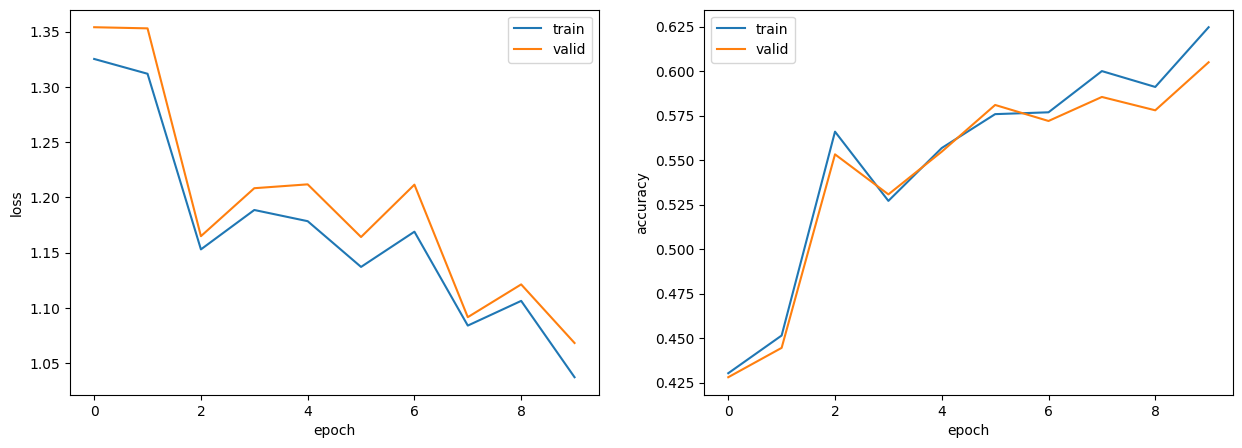

In [15]:
if __name__ == "__main__":
    VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
    EMB_SIZE = 300
    PADDING_IDX = len(set(w2id.id_dict.values()))
    OUTPUT_SIZE = 4
    HIDDEN_SIZE = 50
    NUM_LAYERS = 1
    LEARNING_RATE = 5e-2
    BATCH_SIZE = 32
    NUM_EPOCHS = 10

    device = torch.device("mps")
    model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, device, NUM_LAYERS, emb_weight=weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                    optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

    make_graph_by_logs(log, "./graphs/knock84.png")

    # 損失と精度の計算
    _, acc_train = calc_loss_and_acc(model, dataset_train, device)
    _, acc_test = calc_loss_and_acc(model, dataset_test, device)

    print(f'Train Accuracy: {acc_train:.3f}')
    print(f'Test Accuracy: {acc_test:.3f}')